In [2]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

In [3]:
# pre-trained ResNet101
model = models.resnet101(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/handong/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

In [6]:
# corgie
img = Image.open('./imagenet_samples/corgie.jpg')

img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor()
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print('이미지 텐서 모양: ', img_tensor.size())

이미지 텐서 모양:  torch.Size([1, 3, 224, 224])


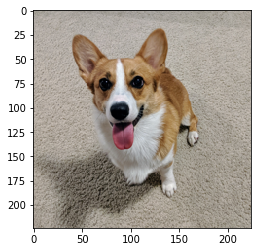

In [12]:
# visualizer
# 시각화를 위해 넘파이 행렬 변환
original_img_view = img_tensor.squeeze(0).detach()  # [1, 3, 244, 244] -> [3, 244, 244]
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

# 텐서 시각화
plt.imshow(original_img_view)

In [14]:
# performance before attack
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print('예측된 라벨 : ', prediction_idx)
print('라벨 이름 : ', prediction_name)

예측된 라벨 :  263
라벨 이름 :  Pembroke, Pembroke Welsh corgi


In [15]:
# fgsm attck
def fgsm_attack(image, epsilon, gradient):
    # sign : 기울기의 방향성 확인
    sign_gradient = gradient.sign()
    # 이미지의 픽셀값을 sign_gradient 방향으로 epsilon만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [18]:
# 적대적 예제 생성
# 이미지의 기울기를 구할 수 있도록 설정
img_tensor.requires_grad_(True)

# 모델에 통과 후 Loss 측정(263 -> 코기)
output = model(img_tensor)
loss = F.nll_loss(output, torch.tensor([263]))

# 기울기 얻어내기 -> grad.data에 입력 이미지 기울기가 저장
model.zero_grad()
loss.backward()

In [19]:
# 기울기 호출
gradient = img_tensor.grad.data

# FGSM
epsilon = 0.03
perturbed_img = fgsm_attack(img_tensor, 0.03, gradient)

In [21]:
# eval
output = model(perturbed_img)

perturbed_prediction = output.max(1, keepdim=False)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print('예측된 라벨 : ', perturbed_prediction_idx)
print('라벨 이름 : ', perturbed_prediction_name)

예측된 라벨 :  172
라벨 이름 :  whippet
